Dataset utilisé ici:
https://universe.roboflow.com/mflyyoloseg/shapedetector

Il faut vous authentifier avec un compte (github par exemple), et veiller à bien exporter les donneée en csv.
Vous obtiendrez les images ainsi qu'un csv "_classes" qui comporte le nom de chaque image ainsi que sa classe donnée sous forme de one-hot encoding.

Autre idée (dataset un peu plus complexe, mais on peut y appliquer les mêmes principes je pense) :
https://universe.roboflow.com/25-tags/5-objects

(Roboflow https://universe.roboflow.com/ c'est bien pour trouver des dataset je trouve) (mais c'est seulement pour du computer vision)

Autre idée (un dataset un peu flippant, c'est des yeux de personnes, de la reconnaissance d'image au volant d'une voiture je crois, le but c'est de savoir si l'oeil est ouvert / fermé, si il porte des lunettes ou non...) (mais c'est pas ouf je trouve) :
http://mrl.cs.vsb.cz/eyedataset

Autre idée : générer des images par IA (gratuit et sans limite) : 
https://perchance.org/ai-text-to-image-generator

## 0) Import the data <a class="anchor" id="0"></a> [↑](#Table-of-contents)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# pour optimiser le code, éviter de faire des boucles for
import itertools as it
import functools

In [22]:
# Read csv
train_df = pd.read_csv("./data/train/_classes.csv", sep=', ', engine="python")

# Mapping int to categories
CLASSES = train_df.columns[1:]
CLASSES_INT = np.arange(len(CLASSES))
cat_to_int = dict(list(zip(CLASSES,CLASSES_INT)))
int_to_cat = dict(list(zip(CLASSES_INT,CLASSES)))

cat_to_int

{'circle': 0,
 'cross': 1,
 'heptagon': 2,
 'hexagon': 3,
 'octagon': 4,
 'pentagon': 5,
 'quartercircle': 6,
 'rectangle': 7,
 'semicircle': 8,
 'square': 9,
 'star': 10,
 'trapezoid': 11,
 'triangle': 12}

The csv presents the filename then the category. This one-hot encoding format is convinient for neural networks, however we will map it into int categories for visualization purposes.

In [23]:
train_df

,filename,circle,cross,heptagon,hexagon,octagon,pentagon,quartercircle,rectangle,semicircle,square,star,trapezoid,triangle
0,270rectangle_rad_50_jpg.rf.d8cb2e97f51001739f9...,0,0,0,0,0,0,0,1,0,0,0,0,0
1,135trapezoid_rad_30_jpg.rf.cfdc844471c790910d3...,0,0,0,0,0,0,0,0,0,0,0,1,0
2,180semicircle_rad_30_jpg.rf.d4bae55fadaf466b67...,0,0,0,0,0,0,0,0,1,0,0,0,0
3,trapezoid_rad_200_jpg.rf.cb30863a474e4ec4fb563...,0,0,0,0,0,0,0,0,0,0,0,1,0
4,135square_rad_50_jpg.rf.d7fde9eaaaedc0d4fe75f2...,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,315hexagon_rad_50_jpg.rf.bae0ff71260774e8541f7...,0,0,0,1,0,0,0,0,0,0,0,0,0
310,315square_rad_200_jpg.rf.bc13b35437a3d9e08f380...,0,0,0,0,0,0,0,0,0,1,0,0,0
311,315octogon_rad_30_jpg.rf.bcbe39704404fcaf9cf99...,0,0,0,0,1,0,0,0,0,0,0,0,0
312,180semicircle_rad_50_jpg.rf.bdd9c3a7b6b38d56c5...,0,0,0,0,0,0,0,0,1,0,0,0,0


We transfer all the names of the images into `X_train_names`.

In [79]:
X_train_names = np.array(train_df['filename'])

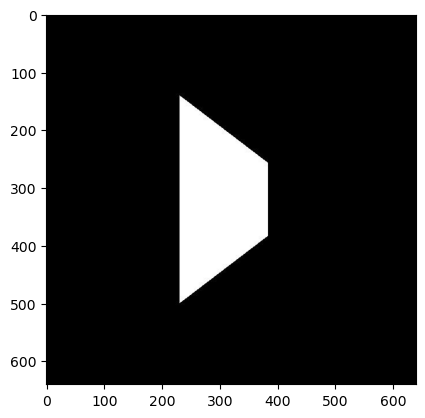

In [80]:
# Read Image name
index = 3
img_name = X_train_names[index]

# Read Image
img = mpimg.imread("./data/train/" + img_name)

# Output Image
plt.imshow(img)

All images are 640 pixels by 640 pixels. Each pixel is dimension 3 : [R,G,B]. Here, the figure is white, i.e. [255,255,255], so we can reduce the dimension in order to have only black and white images.

In [73]:
img.shape

(640, 640, 3)

In [76]:
img[:,:,0].shape

(640, 640)

As for the label, we convert the one-hot encoding into categories in order to obtain `y_train` :

In [52]:
# Mapping into categories
n,m = train_df.shape
y_train = np.zeros(n,'int')

for i in range(n):
    row = train_df.loc[i]
    y_train[i] = np.argmax(row[1:])

y_train

array([ 7, 11,  8, 11,  9, 11, 10,  0,  4,  9,  3,  6,  8,  8,  3,  0, 10,
        8, 11,  5,  0,  7,  5,  7, 12, 12,  4,  2,  9,  2, 12,  3, 10,  3,
       10,  0,  4,  5,  8,  1,  2,  9,  4, 11,  4,  0,  3,  8,  2, 11,  0,
        0,  3,  7, 12,  6, 12, 11,  9,  7, 12,  4,  1, 12, 12,  1,  8,  1,
       10,  4, 11,  7, 11,  2,  2, 12,  4, 10, 10,  3, 10, 12,  1,  4, 12,
        0, 10, 12,  3, 10,  5, 12, 10,  5,  1,  1,  6, 11,  1,  6,  8,  2,
       10,  5, 11, 10, 11, 10,  2,  8,  6,  3,  2,  8,  5, 10,  8,  7,  1,
       11, 12,  2,  6,  9,  1, 12, 11,  1,  6,  9,  7, 11,  9,  8, 10, 11,
        5,  6,  5,  3,  3,  5, 11,  4,  1, 12,  7, 12,  2,  8,  1,  6,  0,
       12,  1,  1, 11,  2, 10,  5,  3,  5, 10,  5,  9, 10,  2,  7,  3,  0,
        2,  7,  9,  0, 12,  2,  7,  0, 11,  1,  2, 11, 12, 11,  6,  6,  6,
        1, 11,  1,  6,  7,  9,  3,  6, 12, 11,  3, 12,  1,  7,  2,  7, 11,
        4, 11,  1,  1,  0,  0, 11,  1,  0,  7,  6,  8, 12,  7,  9,  4,  4,
        0,  3,  8,  7,  2

In [77]:
# Better way to do it (without loop, but index error):

# def onehot_to_int(row):
#     return np.argmax(row[1:])

# y_train = list(map(onehot_to_int,train_df.loc))

We store each image in `X_train` :

In [83]:
def name_to_array(img_name, path="./data/train/"):
    img = mpimg.imread(path + img_name)
    return img[:,:,0]

X_train = np.array(list(map(name_to_array,X_train_names)))
X_train.shape

(314, 640, 640)

Now we can work with `X_train` and `y_train`.

We propose several approaches to feature engineering, like surface area distribution, symmetry, uniformity, and kmeans representation. We also try to complexify the problem adding noise, blurring, displacement and rotation to our images.

## Table of contents

* [0 Import the data](#0)
* [1 Surface area distribution](#1)
* [2 Mean image](#2)
* [3 Symmetry](#3)
* [4 Perimeter](#4)
* [5 Kmeans](#5)
* [6 Adding some blurring](#6)
* [7 Adding some noise](#7)
* [8 A way to deblur images](#8)
* [9 Rotate the image](#9)
* [10 Move the image](#10)
* [11 Classe ImageK](#11)
* [12 AAA](#12)

## 1) Surface area distribution <a class="anchor" id="1"></a> [↑](#Table-of-contents)

In [259]:
# Number of white pixels of each image
white_pixels = np.sum(X_train != 0,axis=(1,2))

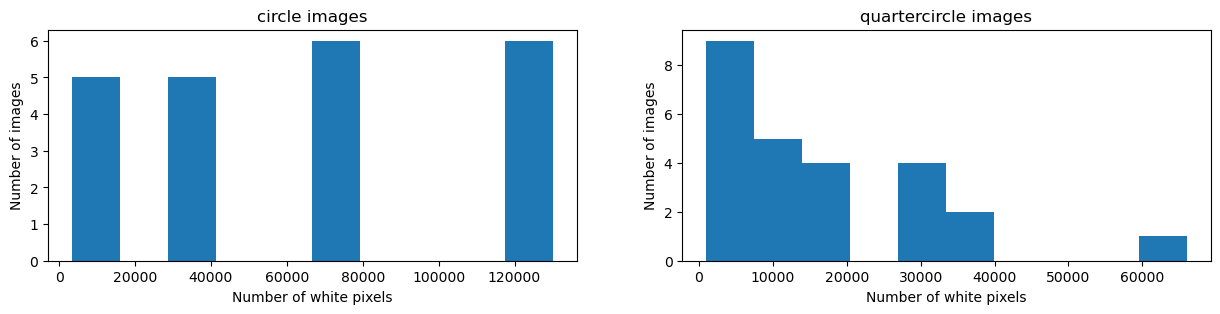

In [260]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

fig, ax = plt.subplots(1,2,figsize=(15, 3))
ax[0].hist(white_pixels[select1])
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[0].set_xlabel("Number of white pixels")
ax[0].set_ylabel("Number of images")

ax[1].hist(white_pixels[select2])
ax[1].set_title(f'{int_to_cat[cat2]} images')
ax[1].set_xlabel("Number of white pixels")
ax[1].set_ylabel("Number of images")

plt.show()

In [ ]:
# à commenter
# un cercle ça a 4 fois plus de surface qu'un quart de cercle typiquement

## 2) Mean image <a class="anchor" id="2"></a> [↑](#Table-of-contents)

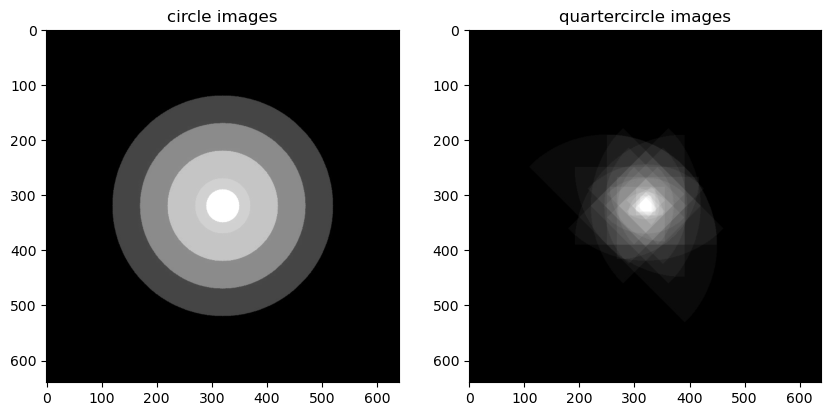

In [181]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

mean_img1 = X_train[select1].mean(axis=0)
mean_img2 = X_train[select2].mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(mean_img1, cmap='gray') 
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[1].imshow(mean_img2, cmap='gray') 
ax[1].set_title(f'{int_to_cat[cat2]} images')
plt.show()

In [ ]:
# à commenter
# pistes à commenter :

# simply need to overcome rotation, dilatation (on va pas le faire pour ne pas donner une solution toute faite)

## 3) Symmetry <a class="anchor" id="3"></a> [↑](#Table-of-contents)

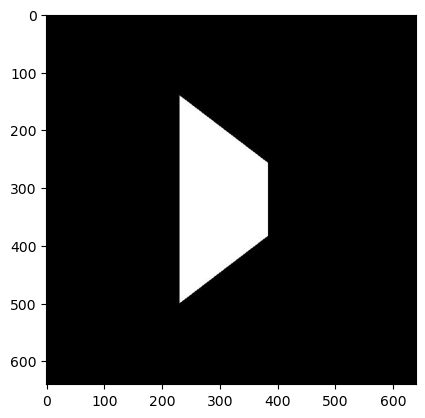

In [227]:
index = 3

Z = X_train[index]
plt.imshow(Z, cmap='gray')

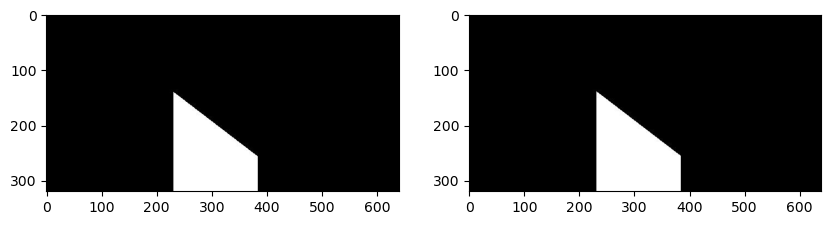

In [235]:
up, down = np.split(Z,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray') 
ax[1].imshow(np.flip(down,0), cmap='gray') 
plt.show()

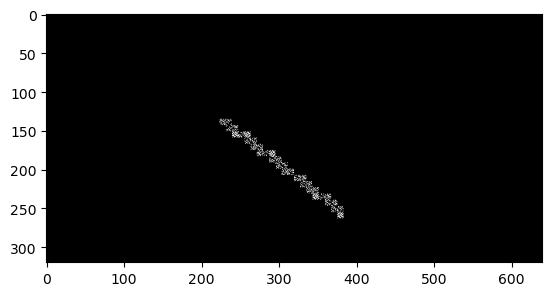

In [236]:
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

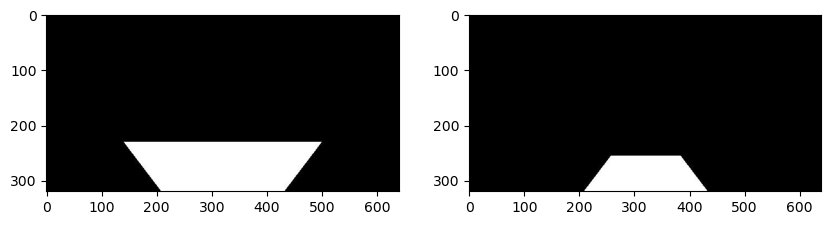

In [237]:
up, down = np.split(Z.T,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray') 
ax[1].imshow(np.flip(down,0), cmap='gray') 
plt.show()

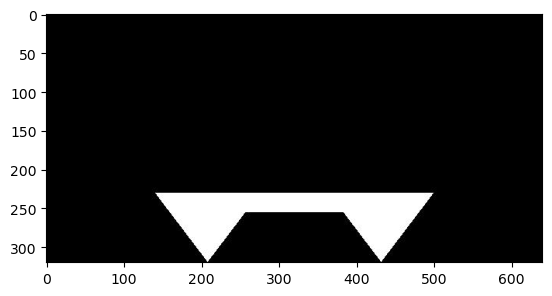

In [238]:
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

In [ ]:
# à commenter
# certaines formes sont symétriques horizontalement ou verticalement
# n'est pas robuste à la rotation
# permet separer cercle, rectangles, croix du reste typiquement

## 4) Perimeter <a class="anchor" id="4"></a> [↑](#Table-of-contents)

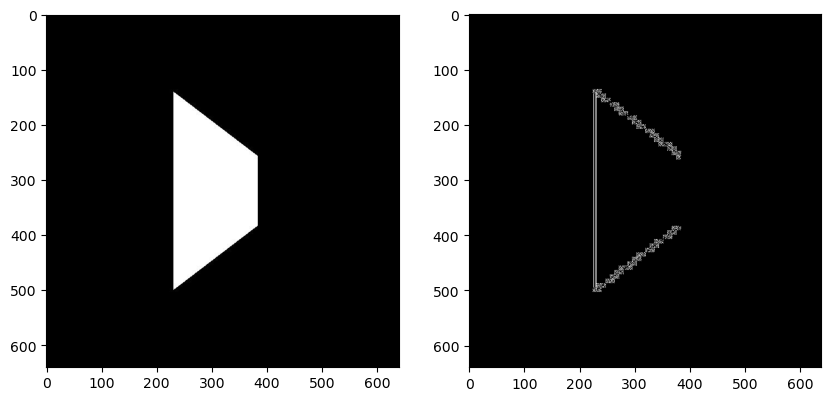

In [276]:
index = 3

Z = X_train[index]
Z_perimeter = np.diff(Z)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[1].imshow(Z_perimeter, cmap='gray')
plt.show()

In [ ]:
# à commenter
# jsp à quoi ça peut servir ^^'
# en vrai, une classe de forme pourrait se définir à travers sa surface et son périmètre
# (tant qu'on arrive à surmonter la dilatation bien sûr)

## 5) Kmeans <a class="anchor" id="5"></a> [↑](#Table-of-contents)

In [167]:
# Pour faire du kmeans
from sklearn.cluster import KMeans

def kmeans(X,K=4):
    
    kmeansX = KMeans(n_clusters=K,max_iter=10).fit(X)
    label = kmeansX.labels_
    center = kmeansX.cluster_centers_
    res = center[kmeansX.labels_]

    return (res,label,center)

On fait du kmeans sur chaque ligne (et colonne) de l'image. Cela nous donne une sorte de convolution :

L'image est résumée en K types de bandes diponibles dans `center`, dont le label est enregistré dans `label`. L'image finale est accessible à travers `res`. 

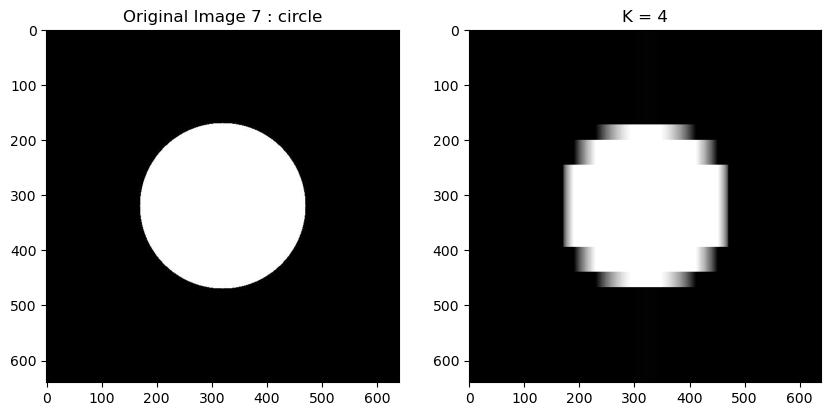

In [220]:
index = 7
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the image
Z = X_train[index]
# Get the category
cat = y_train[index]

if transpose:
    Z = np.transpose(Z)

res,label,center = kmeans(Z,K)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray') 
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray') 
ax[1].set_title(f'K = {K}')
plt.show()

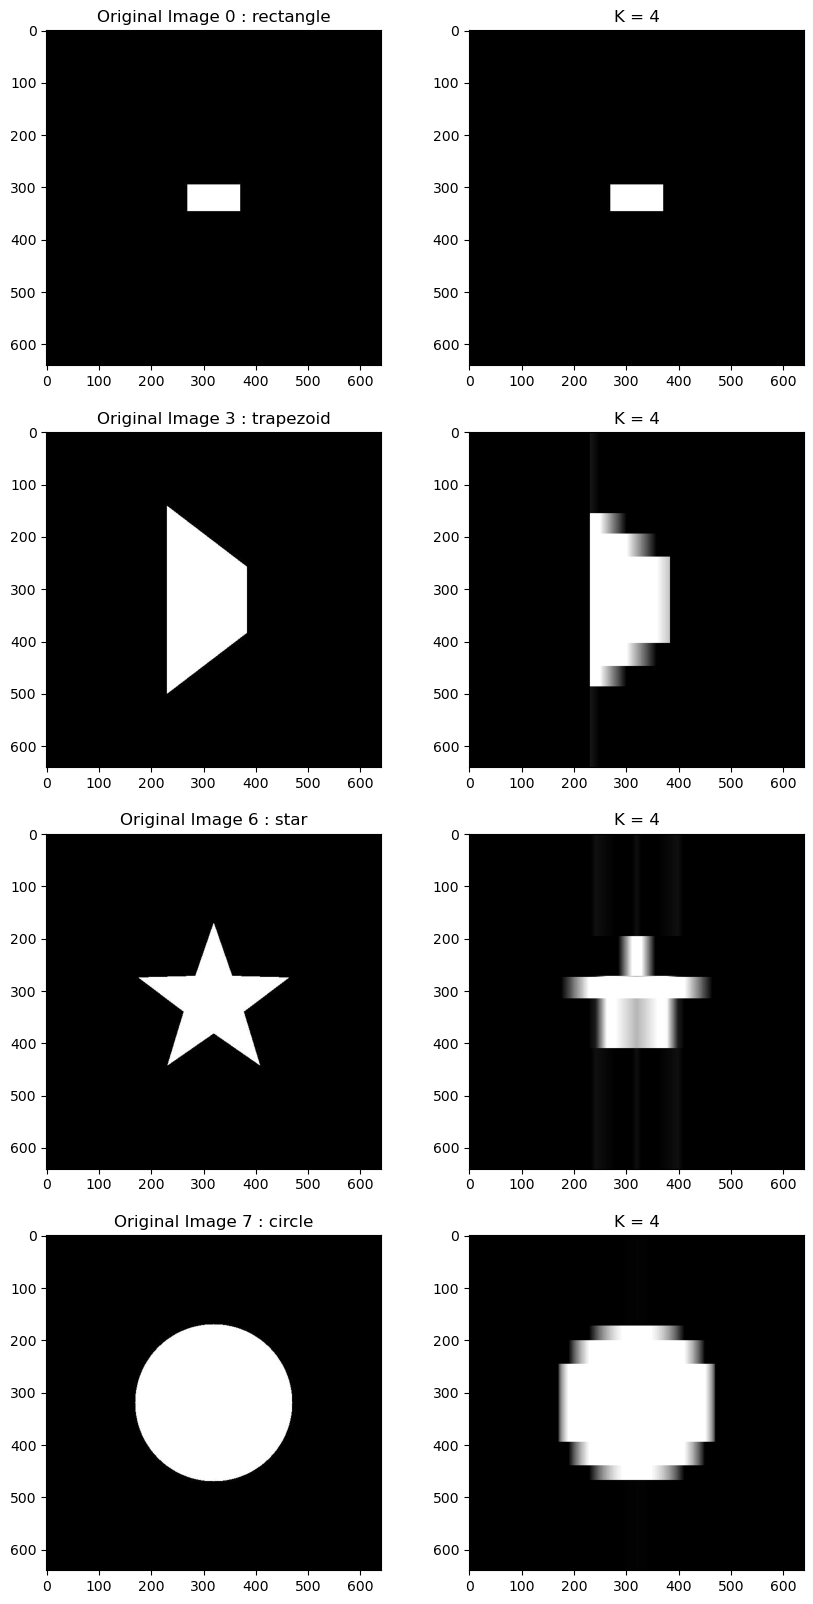

In [223]:
indexes = [0,3,6,7]
n_indexes = len(indexes)
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the images
Z_selected = X_train[indexes]

fig, ax = plt.subplots(n_indexes,2,figsize=(10, n_indexes*5))

for i,index in enumerate(indexes):
    
    # Get the image
    Z = X_train[index]
    # Get the category
    cat = y_train[index]
    
    if transpose:
        Z = np.transpose(Z)
    
    res,label,center = kmeans(Z,K)

    ax[i,0].imshow(Z, cmap='gray') 
    ax[i,0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
    ax[i,1].imshow(res, cmap='gray') 
    ax[i,1].set_title(f'K = {K}')

plt.show()

In [ ]:
# à commenter!!
# pistes intéressantes à commenter :

# comparaison à l'image de base : une étoile est extrement déformée même pour un K grand
# comparaison des bandes entre elles
# comparaison des bandes entre catégorie
# permet de réduire la taille des images (640*640 pour pas tant d'information que ça...)

## 6) Adding some blurring <a class="anchor" id="6"></a> [↑](#Table-of-contents)

In [534]:
from PIL import Image, ImageFilter

def blur_image(img, radius=2):
    """
    Blur the input image and save the result to the output path.
    
    Args:
    img (PIL.Image): Input image.
    radius (int): Blur radius. Higher values result in more blurring.
    
    Returns:
    PIL.Image: Blurred image.
    """
    # Apply the blur filter
    blurred_image = img.filter(ImageFilter.GaussianBlur(radius))

    return blurred_image

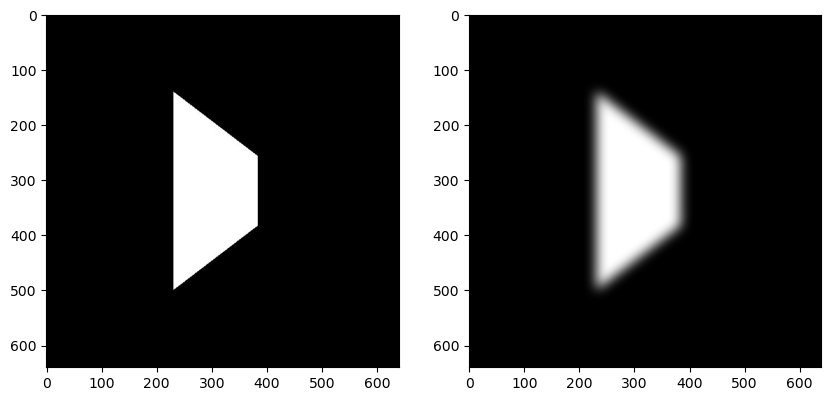

In [423]:
index = 3
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# You can also go back to np array representation with np.array(img)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(blurred_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

## 7) Adding some noise <a class="anchor" id="7"></a> [↑](#Table-of-contents)

In [424]:
def add_noise(image, mean=0, std_dev=1):
    """
    Add Gaussian noise to the given image.
    
    Args:
    image (PIL.Image): Input image.
    mean (float): Mean of the Gaussian noise distribution.
    std_dev (float): Standard deviation of the Gaussian noise distribution.
    
    Returns:
    PIL.Image: Image with added Gaussian noise.
    """
    # Convert image to numpy array
    img_array = np.array(image)
    
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, img_array.shape).astype(np.uint8)
    
    # Add noise to the image
    noisy_image = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    
    # Convert back to PIL image
    noisy_image = Image.fromarray(noisy_image)
    
    return noisy_image

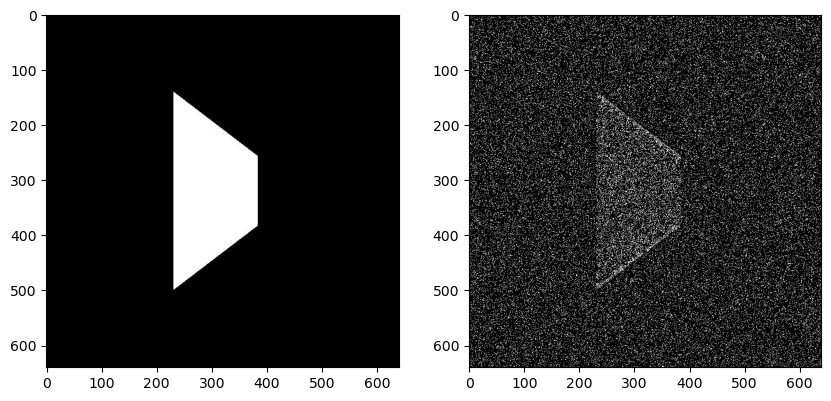

In [435]:
index = 3
mean_noise = 5
std_dev_noise = 5

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
noisy_img = add_noise(img,mean_noise,std_dev_noise)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(noisy_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut
# rajouter du bruit ça peut rendre très difficile la tâche
# typiquement, avec un peu de bruit le kmeans arrive à reconnaitre l'image (genre mean=0,std=1),
# mais dès que mean=5,std=5, kmeans ne reconnait plus rien...
# et c'est vrai qu'avec mean=5,std=5 le signal devient vraiment faible

## 8) A way to deblur images <a class="anchor" id="8"></a> [↑](#Table-of-contents)

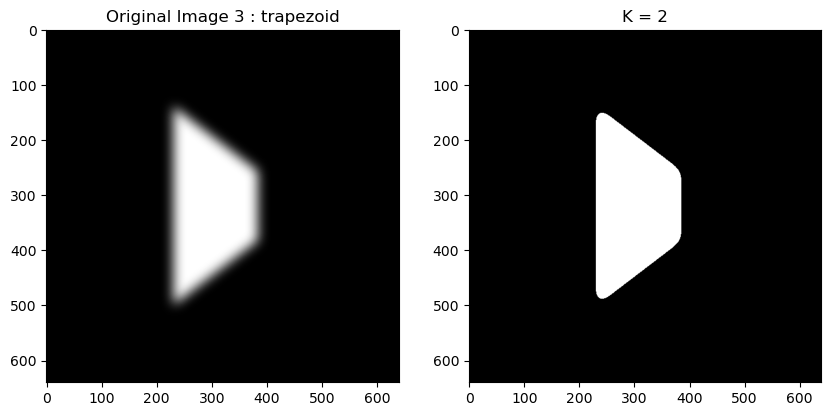

In [458]:
index = 3
K = 2 # Nombre de patternes autorisés
radius = 10
transpose = False # transpose l'image

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# Get the image
if transpose:
    Z = np.array(blurred_img).T.ravel().reshape(-1,1)
else:
    Z = np.array(blurred_img).ravel().reshape(-1,1)

# Get the category
cat = y_train[index]

res,label,center = kmeans(Z,K)

Z = Z.reshape(640,640)
res = res.reshape(640,640)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray') 
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray') 
ax[1].set_title(f'K = {K}')
plt.show()

In [ ]:
# à commenter
# là j'ai fait du kmeans non pas sur les lignes, non pas sur les colonnes, mais carrément sur toute l'image
# K=2 parce qu'on a que du noir et du blanc a priori
# mais on pourrait généraliser à un autre dataset avec K plus grand que 2

# à commenter
# on surmonte carrément le floutage, kmeans est un très bon moyen de résumer l'image!!

## 9) Rotate the image <a class="anchor" id="9"></a> [↑](#Table-of-contents)

In [506]:
def rotate_image(image, angle):
    """
    Rotate the input image by the specified angle.
    
    Args:
    image (PIL.Image): Input image.
    angle (float): Angle of rotation in degrees.
    
    Returns:
    PIL.Image: Rotated image as a NumPy array.
    """
    # Rotate the image
    rotated_image = image.rotate(angle, expand=False)
    
    return rotated_image

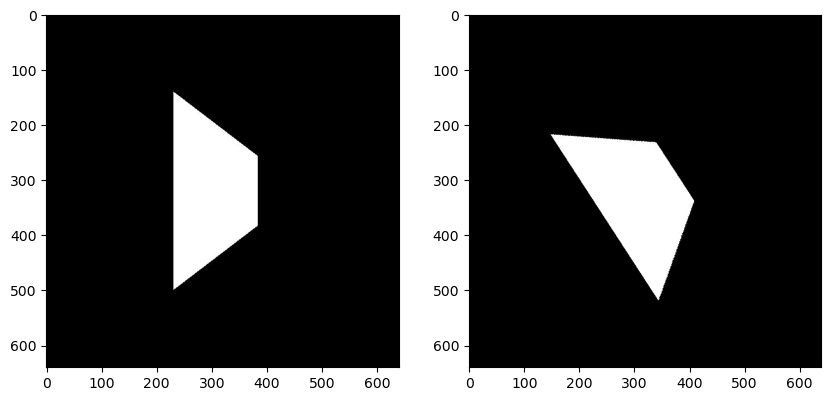

In [507]:
index = 3
angle = 33

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
rotated_image = rotate_image(img,angle)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(rotated_image, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

## 10) Move the image <a class="anchor" id="10"></a> [↑](#Table-of-contents)

In [508]:
def move_image(image, x, y):
    """
    Move the input image by the specified displacements in the x and y directions.
    
    Args:
    image (PIL.Image): Input image.
    output_image_path (str): Path to save the moved image.
    x (int): Displacement in the x direction.
    y (int): Displacement in the y direction.
    """  
    # Move the image
    moved_image = Image.new("RGB", image.size)
    moved_image.paste(image, (x, y))
    
    return moved_image

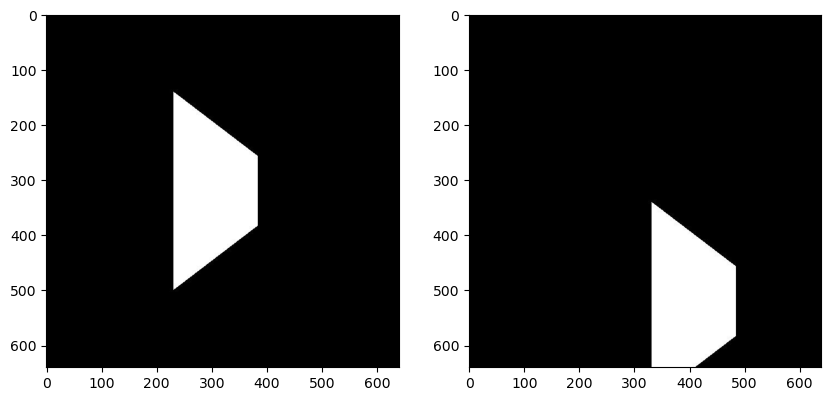

In [509]:
index = 3
x_move = 100
y_move = 200

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
moved_img = move_image(img,x_move,y_move)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(moved_img, cmap='gray')
plt.show()

In [ ]:
# à commenter
# en quoi ça rajoute de la difficulté, quelles approches naives ça pourrait mettre en défaut

## 11) Classe ImageK <a class="anchor" id="11"></a> [↑](#Table-of-contents)

On résume quelques-unes des features explorées à travers la classe `ImageK`.

On définit une image comme étant l'ensemble de paramètres :
- `K` (le nombre de labels)
- `res` (l'image après kmeans i.e. le vecteur de toutes les bandes)
- `label` (le vecteur des labels de chaque bande)
- `center` (le vecteur des K bandes)
- `ass` (un facteur d'assymétrie horizontale i.e. sur la lattitude)
- et de même via la transposée (d'où `assT` l'asymétrie verticale par exemple)

In [535]:
class ImageK():
    def __init__(self,original,K=2,length=640,height=640):
        self.original = original.reshape(length,height)
        self.K = K
        self.length = length
        self.height = height
        self.res, self.label, self.center = kmeans(self.original.reshape(-1,1),K)
        self.res = self.res.reshape(length,height)
        
        # Asymétrie lattidudinale
        up, down = np.split(self.res,2)
        self.ass = np.abs(up-np.flip(down,0)).mean()

        # Asymétrie longitudinale
        up, down = np.split(self.res.T,2)
        self.assT = np.abs(up-np.flip(down,0)).mean()
        
        return

In [541]:
index = 5
K = 2 # Nombre de patternes autorisés
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

img = np.array(img)
blurred_img = np.array(blurred_img)

In [542]:
a = ImageK(blurred_img,K)

In [543]:
a.ass

0.128536810481398

In [544]:
a.assT

9.518150816147523

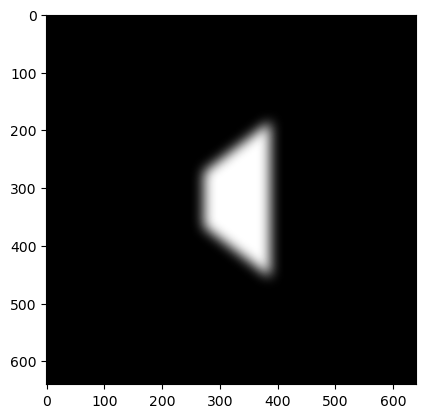

In [545]:
plt.imshow(a.original, cmap='gray')

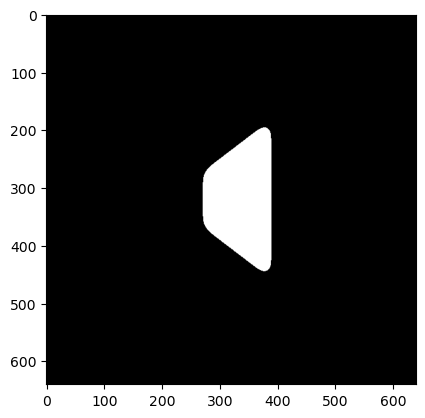

In [546]:
plt.imshow(a.res, cmap='gray')

## 12) TO DO <a class="anchor" id="12"></a> [↑](#Table-of-contents)

In [547]:
# Il reste à proposer un classifieur naif
# j'imagine qu'on peut copier coller le CNN de hot_jupiter ?

# il faut aussi faire une belle introduction, et mettre tout ça au format d'un starting_kit

# le dataset de test contient deux pauvres images, il faudra modifier ça,
# peut-être reconstruire notre propre dataset en y rajoutant les difficultés dont j'ai parlé
# style blurring, rotation, etc...
# Ou bien juste on donne le notebook comme ça, sans toucher au dataset, et on prend comme test
# l'ensemble de validation